In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa

#from keras.layers.core import MaxoutDense
from models.maxout_layers import Maxout1D

#dropout_enable = False

#model_file = "DL1_AntiKt4EMTopo_dropout" if dropout_enable else "DL1_AntiKt4EMTopo"
import models.rebuild_DL1 as DL1
from util import (DL1_score, plot_prob_score, plot_prob_score_from_model,
                  get_mean_score, momentum_space, efficiecy_mean_std)

import h5py

#model = tf.keras.models.load_model("DL1_AntiKt4EMTopo")
#model_dropout = tf.keras.models.load_model("DL1_AntiKt4EMTopo_dropout")
#test_model.summary()
def get_mode_from_root():
    #filename.root:Tdirectory/directory/obj
    File_path="BTagCalibRUN2-08-40.root:DL1/AntiKt4EMTopo/net_configuration"

    DL1_struct = DL1.get_net_struct(File_path)
    DL1_weights = DL1_struct['layers']

    #DL1_layers = [ 72, 57, 60, 48, 36,24, 12, 6]
    DL1_dropouts = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

    #findout input size, and weight matrix for each layer.
    #create corresponding tensorflow layers and store them in a list.
    features, dl1_layers, dl1_weights = DL1.pars_layers(DL1_struct['layers'])

    _model = DL1.get_DL1(features , dl1_layers, drops=None )
    _model_dropout = DL1.get_DL1(features , dl1_layers, drops=DL1_dropouts )
    #model.summary()
    DL1.set_dl1_weights(model=model, weights=dl1_weights)
    DL1.set_dl1_weights(model=model_dropout, weights=dl1_weights)
    return _model, _model_dropout

def load_trained(model_weight):
    import models.binbin_model as binbin_model
    test_model = binbin_model.DL1_model(InputShape=44, training=False)
    test_model_Dropout = binbin_model.DL1_model(InputShape=44, training=True)
    test_model.load_weights(model_weight)
    test_model_Dropout.load_weights(model_weight)
    return test_model, test_model_Dropout

def data_category(data, label,category='b'):
    #1 is b, 2 is c, 4 is light
    label_binary = {'b':2, 'c':1, 'l':0}
    label_index = label_binary[category]
    label_filter = (label[:,label_index]==1)
    print(label_filter)
    return data[label_filter], label[label_filter]
    
    
#get test dataset
hf = h5py.File("/Users/abletimin/cernbox/b-tagg/btagging-ml_tutorial_files/MC16d_ttbar-test-validation_sample-NN.h5", 'r')
X_test, Y_test = hf['X_test'][:], hf['Y_test'][:]
hf.close()

X_test, Y_test = data_category(X_test, Y_test,category='b')


[ True  True  True ... False  True False]


In [2]:
trained_weight="/Users/abletimin/cernbox/b-tagg/trainedModel/DL1r_hybrid_50epochs_3600batch.h5"
model, model_dropout =load_trained(model_weight=trained_weight)


In [3]:
def Eff_pT(X_data, log_bins):
    #no dropout
    _re = model(X_data, training=False).numpy()
    _score = DL1_score(_re[:,2],_re[:,1], _re[:,0])
    
    Hpretag_jetPt, bins = np.histogram(momentum_space(X_data[:,1]), log_bins)
    mask_zeros = (Hpretag_jetPt != 0)
    Hpretag_jetPt, bins = Hpretag_jetPt[mask_zeros] , np.append(log_bins[:-1][mask_zeros], log_bins[sum(mask_zeros)])
    log_bins = bins
    #merge last bin if the number of events is less then 20.
    while Hpretag_jetPt[-1] < 20:
        last_bin = Hpretag_jetPt[-1]
        Hpretag_jetPt = Hpretag_jetPt[:-1]
        Hpretag_jetPt[-1]= Hpretag_jetPt[-1]+last_bin
        log_bins = log_bins[:-2]
        log_bins = np.append(log_bins,bins[-1])
        
    print("pT Bins: ", Hpretag_jetPt)
    Hbtag_jetPt, _ = np.histogram( momentum_space(X_data[(_score>1.45)][:,1]), bins=log_bins)

    btagg_efficiency, eff_errors  = efficiecy_mean_std(X_data, model_dropout, N_forward=500, Nbins=log_bins)
    
    pT_bins = (log_bins[:-1]+log_bins[1:])/2.
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12, 5), sharey=False)
    ax0.plot(pT_bins, Hbtag_jetPt/Hpretag_jetPt,'-',color="red", label="No dropout")
    ax0.plot(pT_bins, btagg_efficiency,'-',color="gray", alpha=0.8, label="With dropout")
    ax0.fill_between(pT_bins, btagg_efficiency- eff_errors,
                 btagg_efficiency+eff_errors, color="gray", alpha=0.6, label="")
    #plt.ylim(0,0.7)
    ax0.legend(loc="upper right")
    
    ax1.plot(pT_bins, eff_errors/btagg_efficiency, 'o', color='black', label="Error")
    ax1.legend(loc="upper left")

pT Bins:  [ 34884 194610 222109 161640  85021  34209  11814   3860   1310    483
    176     85     44]


/Users/abletimin/work/ATLAS/b-tagg/DL1_model/util/tools.py:19: RuntimeWarning: overflow encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))


CPU times: user 1h 1min 28s, sys: 45min 12s, total: 1h 46min 41s
Wall time: 41min 12s


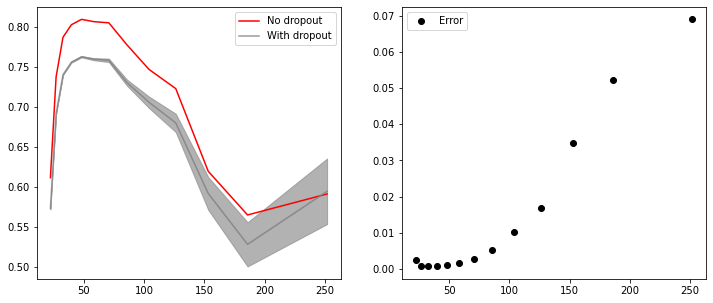

In [4]:
%%time
Eff_pT(X_test, log_bins = np.geomspace(20,300, 15))


### Zprime

In [5]:
#get test dataset
hf = h5py.File("/Users/abletimin/cernbox/b-tagg/btagging-ml_tutorial_files/MC16d_Zprime-test-validation_sample-NN.h5",
               'r')
X_zp, Y_zp = hf['X_test'][:], hf['Y_test'][:]
hf.close()
X_zp, Y_zp = data_category(X_zp, Y_zp,category='b')

[False  True False ... False False False]


pT Bins:  [ 9823 12509  8716  8107  8591 10406 14076 19329 26714 35613 45437 50808
 45966 25656  2480]


/Users/abletimin/work/ATLAS/b-tagg/DL1_model/util/tools.py:19: RuntimeWarning: overflow encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))
/Users/abletimin/work/ATLAS/b-tagg/DL1_model/util/tools.py:19: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(pb/(0.08*pc + 0.92*pl))
/Users/abletimin/work/ATLAS/b-tagg/DL1_model/util/tools.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))


CPU times: user 25min 54s, sys: 8min 44s, total: 34min 38s
Wall time: 14min 35s


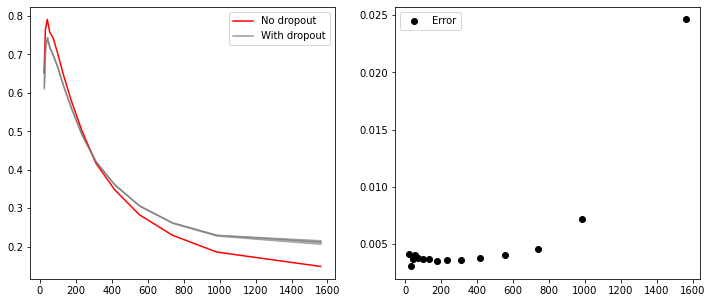

In [6]:
%%time
Eff_pT(X_zp, log_bins = np.geomspace(20,2000, 17))